In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from scipy import stats
import umap
from collections import Counter
from combat.pycombat import pycombat


In [2]:
met_raw_df = pd.read_csv('../data/data_zscore_comp_id.csv')
met_raw_df.set_index(met_raw_df.columns[0], inplace=True)
met_raw_df

,BAYL-08997,BAYL-08998,BAYL-08999,BAYL-09000,BAYL-09001,BAYL-09002,BAYL-09003,BAYL-09004,BAYL-09005,BAYL-09006,...,s_21944,s_22832,s_22842,s_22997,s_23003,s_23077,s_23123,s_22787,s_23294,s_73385
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
42370,-1.259948,0.170557,0.814204,0.038958,-0.504466,-0.757901,-0.986865,0.993000,0.986541,0.000250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,-0.610334,-0.811169,-0.554787,-0.603603,-0.549375,-0.631363,0.606882,1.238204,1.661840,-0.931552,...,-0.434904,-0.730548,-0.009508,-0.607362,0.219333,-0.767359,-0.421440,0.085019,-0.732586,-1.167603
27665,-1.201809,0.387317,-1.062940,0.525122,-0.973446,-0.253533,0.195547,0.769406,0.796718,-0.058625,...,0.825309,2.224161,0.182297,-0.697035,0.161942,-0.266286,0.775185,-0.640354,1.440073,0.458074
38395,-0.954275,-0.906589,4.929942,0.974496,-0.740805,0.642705,-0.293678,0.650630,1.008092,-0.778676,...,-1.505053,-1.112171,0.062801,-0.778621,0.574785,-0.251823,-0.822022,-1.332230,0.767016,-1.741468
437,0.240999,-0.454249,-0.000406,-0.542391,NaN,0.403722,-0.492163,0.252810,-0.517825,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
met_names_df = pd.read_excel('../data/BAYL-04-22MD+ Data Tables Updated.xlsx', sheet_name='Chemical Annotation')
met_names_df = met_names_df.loc[:, ['COMP_ID', 'CHEMICAL_NAME']].sort_values('COMP_ID')  # CHEMICAL_NAME
met_names_df.set_index('COMP_ID', inplace=True)
met_names_df.head()

,CHEMICAL_NAME
COMP_ID,
53,glutamine
54,tryptophan
55,beta-alanine
56,cystine
57,glutamate


In [4]:
clin_df = pd.read_csv('../data/sampleAttr.csv', index_col=0)
# Exclude ASPRE LR
clin_df = clin_df[clin_df['STUDY'] != 'ASPRE_LR']
clin_df

,ga.w,ASA_tri_chr,weight,crl,smoking,trimester,pe,ptIDs,consss_batch,BErm,conception,ASA,prev.pe,age,Compliance,height,STUDY,sle,race
sIDs,,,,,,,,,,,,,,,,,,,
BAYL-08997,13.400000,ASA - 1st Trimester,45.1,55.3,0,1,1.0,S1_1_Ca,batch-2023,batch_2023,7,True,7,36.64887063655031,94.444444,150,CHUK,0,Chinese
BAYL-08998,13.700000,ASA - 1st Trimester,82.2,63.1,0,1,1.0,S1_2_Ca,batch-2023,batch_2023,7,True,2,32.309377138945926,94.267516,171,CHUK,0,Chinese
BAYL-08999,13.400000,ASA - 1st Trimester,69.6,58.8,0,1,0.0,S1_1_Co,batch-2023,batch_2023,7,True,7,43.90143737166324,99.367089,161,CHUK,0,Chinese
BAYL-09000,14.600000,ASA - 1st Trimester,51.4,62.9,0,1,0.0,S1_2_Co,batch-2023,batch_2023,7,True,7,33.11430527036276,98.684211,154,CHUK,0,Chinese
BAYL-09001,13.100000,ASA - 1st Trimester,39.2,45.3,0,1,0.0,S1_4_Co,batch-2023,batch_2023,7,True,7,24.32032854209445,95.597484,161,CHUK,0,Chinese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,21.600000,PLACEBO - 2nd Trimester,71.0,60.2,No,2,0.0,pt_755998,batch-2021,batch_2021,Spontaneous,False,Multip-no PE,33.8562628336756,0.000000,162.0,from-2015,No,Black
s_23123,22.000000,PLACEBO - 2nd Trimester,58.1,53.6,No,2,0.0,pt_727062,batch-2021,batch_2021,Spontaneous,False,Nullip,25.3141683778234,0.000000,155.0,from-2015,No,Black
s_22787,22.100000,PLACEBO - 2nd Trimester,93.8,59.3,No,2,0.0,pt_20889,batch-2021,batch_2021,Spontaneous,False,Multip-no PE,29.7659137577002,0.000000,163.0,from-2015,No,Black


# Merge and preprocess data

In [5]:
met_raw_df = met_raw_df.loc[:, clin_df.index]  # Take only columns that exist in clinical data
met_raw_df

sIDs,BAYL-08997,BAYL-08998,BAYL-08999,BAYL-09000,BAYL-09001,BAYL-09002,BAYL-09003,BAYL-09004,BAYL-09005,BAYL-09006,...,s_21944,s_22832,s_22842,s_22997,s_23003,s_23077,s_23123,s_22787,s_23294,s_73385
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
42370,-1.259948,0.170557,0.814204,0.038958,-0.504466,-0.757901,-0.986865,0.993000,0.986541,0.000250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,-0.610334,-0.811169,-0.554787,-0.603603,-0.549375,-0.631363,0.606882,1.238204,1.661840,-0.931552,...,-0.434904,-0.730548,-0.009508,-0.607362,0.219333,-0.767359,-0.421440,0.085019,-0.732586,-1.167603
27665,-1.201809,0.387317,-1.062940,0.525122,-0.973446,-0.253533,0.195547,0.769406,0.796718,-0.058625,...,0.825309,2.224161,0.182297,-0.697035,0.161942,-0.266286,0.775185,-0.640354,1.440073,0.458074
38395,-0.954275,-0.906589,4.929942,0.974496,-0.740805,0.642705,-0.293678,0.650630,1.008092,-0.778676,...,-1.505053,-1.112171,0.062801,-0.778621,0.574785,-0.251823,-0.822022,-1.332230,0.767016,-1.741468
437,0.240999,-0.454249,-0.000406,-0.542391,NaN,0.403722,-0.492163,0.252810,-0.517825,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
met_df = met_raw_df.merge(met_names_df, left_index=True, right_index=True)
met_df.set_index('CHEMICAL_NAME', inplace=True)
met_df = met_df.T
# met_df.loc[:, 'pe'] = clin_df['pe']
# met_df = met_df[clin_df['trimester'] == 3]
print(f'Initial number of metabolites: {met_df.shape[1]}')
met_df = met_df.loc[:, met_df.isnull().sum() < 0.2*met_df.shape[0]]  # Fill rate > 80%
print(f'Number of metabolites after Fill rate > 80% filter: {met_df.shape[1]}')
met_df = met_df[list(filter(lambda x: 'x' not in x.lower(), met_df.columns))]
print(f'Number of metabolites after removing X-molecules: {met_df.shape[1]}')
met_df = met_df.fillna(met_df.min())
met_df

Initial number of metabolites: 968
Number of metabolites after Fill rate > 80% filter: 736
Number of metabolites after removing X-molecules: 525


CHEMICAL_NAME,spermidine,1-methylnicotinamide,"12,13-DiHOME",alpha-ketoglutarate,kynurenate,3-phosphoglycerate,cholate,"5,6-dihydrothymine","9,10-DiHOME",linoleate (18:2n6),...,glycine conjugate of C10H14O2 (1)*,"sphingomyelin (d17:1/14:0, d16:1/15:0)*",6-bromotryptophan,dodecadienoate (12:2)*,N-acetyl-isoputreanine,glucuronide of piperine metabolite C17H21NO3 (4)*,sulfate of piperine metabolite C16H19NO3 (2)*,sulfate of piperine metabolite C16H19NO3 (3)*,sulfate of piperine metabolite C18H21NO3 (1)*,sulfate of piperine metabolite C18H21NO3 (3)*
BAYL-08997,-0.610334,-1.201809,-0.954275,-0.485987,0.598959,-0.660514,-0.355321,-0.898309,-0.667690,-0.874199,...,-0.939114,-0.838303,-1.399022,-0.656606,-1.702764,-0.667845,-0.884692,-0.810793,-0.770932,-0.683563
BAYL-08998,-0.811169,0.387317,-0.906589,-0.409053,0.612680,0.001887,-0.108802,-0.111114,-0.696468,-0.820280,...,-0.396659,-0.697519,0.887825,-1.112439,-0.969079,-1.029021,-0.466641,-0.426476,-0.438533,-0.397876
BAYL-08999,-0.554787,-1.062940,4.929942,0.022588,3.050217,-0.142467,-0.215959,-0.479178,2.368797,1.660334,...,0.851302,-0.742232,-0.390750,0.301971,-0.991800,0.009966,-0.514876,-0.396405,-0.244924,0.445289
BAYL-09000,-0.603603,0.525122,0.974496,-0.494779,-0.347355,-0.359097,-0.335079,-0.369941,0.309919,-0.618017,...,-0.487078,-0.952760,1.479042,-0.445710,-0.805737,-0.751043,-0.781056,-0.756450,-0.922030,-0.847816
BAYL-09001,-0.549375,-0.973446,-0.740805,-0.049422,-0.787278,-0.515097,-0.176998,4.681018,-0.627905,0.940678,...,1.260862,-0.534981,0.603498,1.521883,-0.866545,-0.341395,0.272540,0.212023,-0.165409,0.366029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-0.767359,-0.266286,-0.251823,0.162015,-2.564631,-0.809305,-0.028283,-0.336513,-0.733505,-1.243590,...,-0.756449,1.115718,-1.628595,-3.419015,-0.335398,-0.141188,1.051963,0.962210,1.060235,0.956444
s_23123,-0.421440,0.775185,-0.822022,-0.091252,-1.624241,-0.779540,-0.168885,-1.447742,-0.977625,-1.101853,...,-1.007543,0.400393,-1.121863,-1.153469,-0.352297,-0.400432,0.283153,0.157192,0.443618,0.300457
s_22787,0.085019,-0.640354,-1.332230,0.534896,-2.285493,-0.649324,0.127443,-0.342412,-2.082006,-1.367824,...,-0.008867,-0.175965,-1.298844,-2.070522,0.141490,-0.437914,0.469147,0.512265,0.648034,0.539695
s_23294,-0.732586,1.440073,0.767016,-0.599035,-1.277730,-1.076107,-2.074105,-0.264915,1.019940,-0.965180,...,-1.569176,1.376506,0.067642,-1.343205,-0.396227,1.330839,1.435338,1.397590,1.336402,1.233001


# Remove batch effects

In [7]:
clin_df.loc[:, 'STUDY'] = clin_df.loc[:, 'STUDY'].apply(lambda x: x.replace('from-2015', 'previous study'))
batches = list(clin_df['STUDY'].unique())
batches_dict = {k: v for v, k in enumerate(batches)}
umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(met_df)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


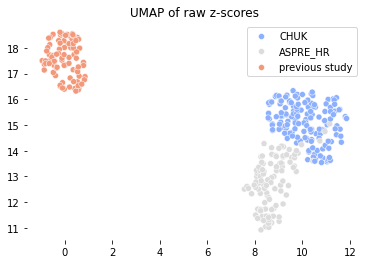

In [8]:
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=clin_df['STUDY'].apply(lambda x: batches[batches_dict[x]]).values, palette='coolwarm')
plt.title('UMAP of raw z-scores')
plt.box(False)
# plt.savefig('umap_before_batch.png', dpi=250, bbox_inches='tight')
plt.show()

In [9]:
met_df_corrected = pycombat(met_df.T, clin_df['STUDY'].values).T

Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


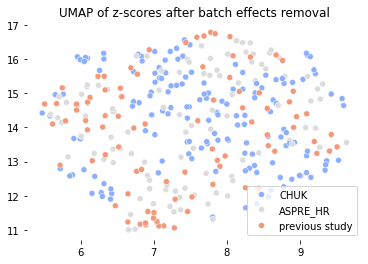

In [10]:
umap_result_corrected = umap_model.fit_transform(met_df_corrected)
sns.scatterplot(x=umap_result_corrected[:, 0], y=umap_result_corrected[:, 1], hue=clin_df['STUDY'].apply(lambda x: batches[batches_dict[x]]).values, palette='coolwarm')
plt.title('UMAP of z-scores after batch effects removal')
plt.box(False)
plt.savefig('umap_after_batch.png', dpi=250)
plt.show()
plt.show()

In [11]:
outliers = set()  #set(clin_df.iloc[umap_result_corrected[:, 0] < 8.5, :].index)  # Check UMAP then set threshold
met_df_corr_filt = met_df_corrected[~met_df_corrected.index.isin(outliers)].copy()
met_df_corr_filt.loc[:, 'pe'] = clin_df['pe']
met_df_corr_filt.loc[:, 'ga.w'] = clin_df['ga.w']
met_df_corr_filt.loc[:, 'ASA'] = clin_df['ASA']
clin_filt_df = clin_df[~clin_df.index.isin(outliers)]
met_df_corr_filt.shape

(344, 528)

In [12]:
met_df_corr_filt

CHEMICAL_NAME,spermidine,1-methylnicotinamide,"12,13-DiHOME",alpha-ketoglutarate,kynurenate,3-phosphoglycerate,cholate,"5,6-dihydrothymine","9,10-DiHOME",linoleate (18:2n6),...,dodecadienoate (12:2)*,N-acetyl-isoputreanine,glucuronide of piperine metabolite C17H21NO3 (4)*,sulfate of piperine metabolite C16H19NO3 (2)*,sulfate of piperine metabolite C16H19NO3 (3)*,sulfate of piperine metabolite C18H21NO3 (1)*,sulfate of piperine metabolite C18H21NO3 (3)*,pe,ga.w,ASA
BAYL-08997,-0.286571,-0.815834,-0.870362,-0.214411,0.177038,-0.390501,-0.335638,-0.888478,-0.850481,-0.896163,...,-0.959272,-1.473403,-0.524333,-0.721080,-0.663478,-0.673977,-0.506003,1.0,13.400000,True
BAYL-08998,-0.602523,0.685851,-0.835227,-0.071667,0.187460,0.649138,0.109823,-0.139081,-0.880518,-0.843660,...,-1.395096,-0.714445,-0.856199,-0.215846,-0.186106,-0.241607,-0.175867,1.0,13.700000,True
BAYL-08999,-0.199185,-0.684607,3.465233,0.729203,2.038830,0.422575,-0.083810,-0.489472,2.318804,1.571811,...,-0.042775,-0.737948,0.098474,-0.274140,-0.148754,0.010231,0.798479,0.0,13.400000,True
BAYL-09000,-0.275981,0.816073,0.550790,-0.230724,-0.541711,0.082574,-0.299062,-0.385480,0.169883,-0.646709,...,-0.757635,-0.545475,-0.600779,-0.595831,-0.595977,-0.870518,-0.695810,0.0,14.600000,True
BAYL-09001,-0.190670,-0.600036,-0.713074,0.595595,-0.875843,-0.162268,-0.013408,4.422950,-0.808956,0.871054,...,1.123586,-0.608379,-0.224374,0.677488,0.606995,0.113661,0.706888,0.0,13.100000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.104168,-0.737232,0.354517,0.051595,-1.610757,-0.909409,-0.153698,-0.033276,-0.282290,-0.719215,...,-1.788862,0.144833,-0.670509,0.428230,0.410241,0.484324,0.349684,0.0,21.600000,False
s_23123,-0.426422,0.242386,-0.705730,-0.271371,-0.703841,-0.857799,-0.245339,-1.493998,-0.537797,-0.569394,...,-0.141950,0.124281,-0.923275,-0.303200,-0.402520,-0.099562,-0.215420,0.0,22.000000,False
s_22787,0.565867,-1.089084,-1.654426,0.527096,-1.341556,-0.632016,-0.052199,-0.041030,-1.693692,-0.850535,...,-0.808591,0.724791,-0.959821,-0.126248,-0.044032,0.094003,-0.009327,0.0,22.100000,False
s_23294,-1.036038,0.867787,2.248981,-0.918900,-0.369665,-1.372020,-1.487119,0.060840,1.552945,-0.424926,...,-0.279877,0.070856,0.764732,0.792966,0.849809,0.745832,0.587926,0.0,22.100000,False


In [13]:
# Read again metabolite names now with Chemical name
met_names_df = pd.read_excel('../data/BAYL-04-22MD+ Data Tables Updated.xlsx', sheet_name='Chemical Annotation')
met_names_df = met_names_df.loc[:, ['CHEMICAL_NAME', 'CHEM_ID']]
met_names_dict = {x[0]: x[1] for x in met_names_df.values}
met_names_dict['pe'] = 'pe'
met_names_dict['ga.w'] = 'ga.w'
met_names_dict['ASA'] = 'ASA'
met_names_df.set_index('CHEMICAL_NAME', inplace=True)
met_names_df.head()


met_df_corr_filt.columns = [met_names_dict[x] for x in met_df_corr_filt.columns]
met_df_corr_filt

,50,55,62,93,98,132,136,158,179,180,...,100020478,100020487,100020492,100020496,100020497,100020502,100020504,pe,ga.w,ASA
BAYL-08997,-0.286571,-0.815834,-0.870362,-0.214411,0.177038,-0.390501,-0.335638,-0.888478,-0.850481,-0.896163,...,-0.959272,-1.473403,-0.524333,-0.721080,-0.663478,-0.673977,-0.506003,1.0,13.400000,True
BAYL-08998,-0.602523,0.685851,-0.835227,-0.071667,0.187460,0.649138,0.109823,-0.139081,-0.880518,-0.843660,...,-1.395096,-0.714445,-0.856199,-0.215846,-0.186106,-0.241607,-0.175867,1.0,13.700000,True
BAYL-08999,-0.199185,-0.684607,3.465233,0.729203,2.038830,0.422575,-0.083810,-0.489472,2.318804,1.571811,...,-0.042775,-0.737948,0.098474,-0.274140,-0.148754,0.010231,0.798479,0.0,13.400000,True
BAYL-09000,-0.275981,0.816073,0.550790,-0.230724,-0.541711,0.082574,-0.299062,-0.385480,0.169883,-0.646709,...,-0.757635,-0.545475,-0.600779,-0.595831,-0.595977,-0.870518,-0.695810,0.0,14.600000,True
BAYL-09001,-0.190670,-0.600036,-0.713074,0.595595,-0.875843,-0.162268,-0.013408,4.422950,-0.808956,0.871054,...,1.123586,-0.608379,-0.224374,0.677488,0.606995,0.113661,0.706888,0.0,13.100000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.104168,-0.737232,0.354517,0.051595,-1.610757,-0.909409,-0.153698,-0.033276,-0.282290,-0.719215,...,-1.788862,0.144833,-0.670509,0.428230,0.410241,0.484324,0.349684,0.0,21.600000,False
s_23123,-0.426422,0.242386,-0.705730,-0.271371,-0.703841,-0.857799,-0.245339,-1.493998,-0.537797,-0.569394,...,-0.141950,0.124281,-0.923275,-0.303200,-0.402520,-0.099562,-0.215420,0.0,22.000000,False
s_22787,0.565867,-1.089084,-1.654426,0.527096,-1.341556,-0.632016,-0.052199,-0.041030,-1.693692,-0.850535,...,-0.808591,0.724791,-0.959821,-0.126248,-0.044032,0.094003,-0.009327,0.0,22.100000,False
s_23294,-1.036038,0.867787,2.248981,-0.918900,-0.369665,-1.372020,-1.487119,0.060840,1.552945,-0.424926,...,-0.279877,0.070856,0.764732,0.792966,0.849809,0.745832,0.587926,0.0,22.100000,False


In [14]:
# ── Per-trimester GA shift: train on noPE (90%), validate on held-out noPE (10%), infer on PE ──
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from scipy.stats import ttest_rel

np.random.seed(42)

# ── CONFIG: choose model ─────────────────────────────────────────────────────
MODEL_TYPE = 'xgb'  # 'xgb' = SelectKBest + XGBoost  |  'pls' = PLS Regression
K_BEST = 50          # number of features for SelectKBest (only used with 'xgb')
# ──────────────────────────────────────────────────────────────────────────────

feature_cols = [c for c in met_df_corr_filt.columns if c not in ['pe', 'ga.w', 'ASA']]
trimester = clin_filt_df.loc[met_df_corr_filt.index, 'trimester']

print(f"Model: {MODEL_TYPE.upper()}" + (f"  |  SelectKBest k={K_BEST}" if MODEL_TYPE == 'xgb' else ''))
print(f"Features available: {len(feature_cols)}")


def build_model(X_train, y_train):
    """Build and return a fitted model + selected feature mask."""
    if MODEL_TYPE == 'pls':
        max_comp = min(10, len(X_train) - 1)
        cv_mse = {n: -cross_val_score(PLSRegression(n_components=n),
                                      X_train, y_train, cv=5,
                                      scoring='neg_mean_squared_error').mean()
                  for n in range(1, max_comp + 1)}
        best_n = min(cv_mse, key=cv_mse.get)
        print(f"  PLS components: {best_n}  |  Train CV RMSE: {np.sqrt(cv_mse[best_n]):.2f} w")
        model = PLSRegression(n_components=best_n).fit(X_train, y_train)
        return model, None  # PLS uses all features

    else:  # xgb
        k = min(K_BEST, X_train.shape[1])
        selector = SelectKBest(f_regression, k=k).fit(X_train, y_train)
        X_sel = selector.transform(X_train)

        xgb = XGBRegressor(
            n_estimators=300, max_depth=4, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            reg_alpha=1.0, reg_lambda=2.0,
            random_state=42, verbosity=0
        )
        # CV on selected features
        cv_rmse = np.sqrt(-cross_val_score(
            xgb, X_sel, y_train, cv=5, scoring='neg_mean_squared_error'
        ).mean())
        print(f"  XGB (k={k})  |  Train 5-fold CV RMSE: {cv_rmse:.2f} w")

        xgb.fit(X_sel, y_train)
        return xgb, selector


def predict(model, selector, X):
    if selector is not None:
        X = selector.transform(X)
    pred = model.predict(X)
    return pred.ravel() if pred.ndim > 1 else pred


def train_and_evaluate(group_data, group_label):
    """Train on 90% noPE (stratified by trimester), validate on 10%, predict PE."""
    noPE = group_data[group_data['pe'] == 0.0].copy()
    PE = group_data[group_data['pe'] == 1.0].copy()
    noPE_tri = trimester.loc[noPE.index]

    print(f"\n{'='*60}")
    print(f"  {group_label}  —  noPE: {len(noPE)},  PE: {len(PE)}")
    print(f"{'='*60}")

    # Stratified 90/10 split on noPE by trimester
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    train_idx, test_idx = next(sss.split(noPE, noPE_tri))

    noPE_train = noPE.iloc[train_idx]
    noPE_test = noPE.iloc[test_idx]

    X_train = noPE_train[feature_cols].values
    y_train = noPE_train['ga.w'].values
    X_test = noPE_test[feature_cols].values
    y_test = noPE_test['ga.w'].values

    print(f"  Train noPE: {len(noPE_train)}  |  Test noPE: {len(noPE_test)}")
    for tri in [1, 2, 3]:
        n_tr = (trimester.loc[noPE_train.index] == tri).sum()
        n_te = (trimester.loc[noPE_test.index] == tri).sum()
        print(f"    Trimester {tri}  —  train: {n_tr},  test: {n_te}")

    # Build model
    model, selector = build_model(X_train, y_train)

    # Validate on held-out 10% noPE
    y_test_pred = predict(model, selector, X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    print(f"  Test noPE RMSE: {test_rmse:.2f} w  |  R²: {test_r2:.3f}")

    # Predict on all PE samples
    PE_pred = predict(model, selector, PE[feature_cols].values)
    PE_real = PE['ga.w'].values
    PE_tri = trimester.loc[PE.index].values

    return model, selector, noPE_test, y_test, y_test_pred, PE, PE_real, PE_pred, PE_tri


# Run for both groups
pla_model, pla_sel, pla_test, pla_y_test, pla_y_test_pred, pla_PE, pla_PE_real, pla_PE_pred, pla_PE_tri = \
    train_and_evaluate(met_df_corr_filt[met_df_corr_filt['ASA'] == False], 'PLACEBO')

asa_model, asa_sel, asa_test, asa_y_test, asa_y_test_pred, asa_PE, asa_PE_real, asa_PE_pred, asa_PE_tri = \
    train_and_evaluate(met_df_corr_filt[met_df_corr_filt['ASA'] == True], 'ASPIRIN')


Model: XGB  |  SelectKBest k=50
Features available: 525

  PLACEBO  —  noPE: 96,  PE: 97
  Train noPE: 86  |  Test noPE: 10
    Trimester 1  —  train: 14,  test: 2
    Trimester 2  —  train: 23,  test: 2
    Trimester 3  —  train: 49,  test: 6
  XGB (k=50)  |  Train 5-fold CV RMSE: 4.07 w
  Test noPE RMSE: 3.13 w  |  R²: 0.843

  ASPIRIN  —  noPE: 74,  PE: 77
  Train noPE: 66  |  Test noPE: 8
    Trimester 1  —  train: 22,  test: 3
    Trimester 2  —  train: 22,  test: 2
    Trimester 3  —  train: 22,  test: 3
  XGB (k=50)  |  Train 5-fold CV RMSE: 3.08 w
  Test noPE RMSE: 2.17 w  |  R²: 0.910


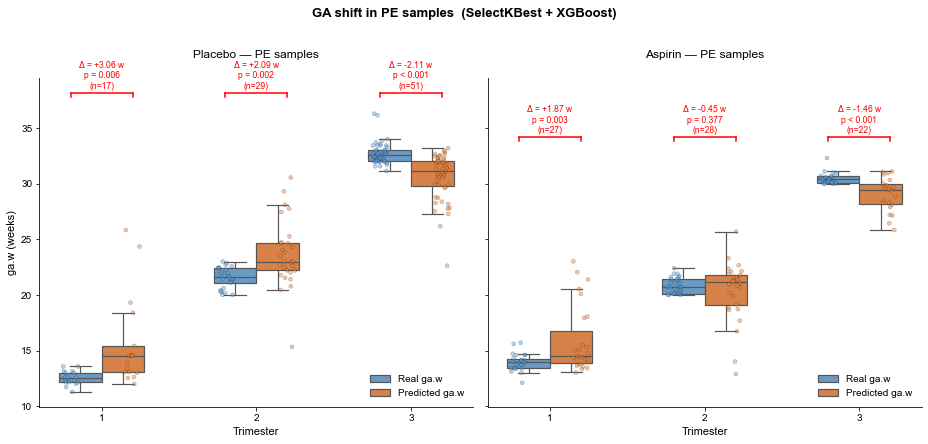

In [15]:
# ── Figure: Real vs Predicted ga.w for PE samples, per trimester ──────────────
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'normal'

model_label = 'SelectKBest + XGBoost' if MODEL_TYPE == 'xgb' else 'PLS Regression'
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
palette = {'Real ga.w': '#5A9BD5', 'Predicted ga.w': '#ED7D31'}

def plot_panel(ax, PE_real, PE_pred, PE_tri, title):
    """Plot real vs predicted ga.w for PE samples per trimester."""
    rows = []
    for real, pred, tri in zip(PE_real, PE_pred, PE_tri):
        rows.append({'Trimester': int(tri), 'Type': 'Real ga.w', 'ga.w': real})
        rows.append({'Trimester': int(tri), 'Type': 'Predicted ga.w', 'ga.w': pred})
    df = pd.DataFrame(rows)

    sns.boxplot(x='Trimester', y='ga.w', hue='Type', data=df,
                palette=palette, width=0.55, hue_order=['Real ga.w', 'Predicted ga.w'],
                order=[1, 2, 3], showfliers=False, ax=ax, linewidth=1.2)
    sns.stripplot(x='Trimester', y='ga.w', hue='Type', data=df,
                  palette=palette, hue_order=['Real ga.w', 'Predicted ga.w'],
                  order=[1, 2, 3], dodge=True, alpha=0.45, size=4,
                  edgecolor='k', linewidth=0.3, ax=ax)

    # Compute and annotate GA shift per trimester
    y_max = df['ga.w'].max()
    bracket_y = y_max + 1.5
    for idx, tri in enumerate([1, 2, 3]):
        mask_tri = PE_tri == tri
        if mask_tri.sum() < 2:
            continue
        real_vals = PE_real[mask_tri]
        pred_vals = PE_pred[mask_tri]
        shift = pred_vals.mean() - real_vals.mean()
        # Paired t-test (same samples, real vs predicted)
        _, p_val = ttest_rel(pred_vals, real_vals)

        # Red bracket
        tick_h = 0.4
        bl, br = idx - 0.2, idx + 0.2
        ax.plot([bl, bl], [bracket_y, bracket_y + tick_h], color='red', lw=1.5)
        ax.plot([br, br], [bracket_y, bracket_y + tick_h], color='red', lw=1.5)
        ax.plot([bl, br], [bracket_y + tick_h, bracket_y + tick_h], color='red', lw=1.5)

        sig = 'p < 0.001' if p_val < 0.001 else f'p = {p_val:.3f}'
        ax.text(idx, bracket_y + tick_h + 0.2,
                f'$\\Delta$ = {shift:+.2f} w\n{sig}\n(n={mask_tri.sum()})',
                ha='center', va='bottom', fontsize=8.5, color='red')

    ax.set_title(title, fontsize=12, weight='normal', pad=20)
    ax.set_ylabel('ga.w (weeks)', fontsize=11)
    ax.set_xlabel('Trimester', fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Deduplicate legend
    h, l = ax.get_legend_handles_labels()
    seen, uh, ul = set(), [], []
    for handle, label in zip(h, l):
        if label not in seen:
            seen.add(label)
            uh.append(handle)
            ul.append(label)
    ax.legend(uh, ul, fontsize=10, frameon=False)

plot_panel(axes[0], pla_PE_real, pla_PE_pred, pla_PE_tri, f'Placebo — PE samples')
plot_panel(axes[1], asa_PE_real, asa_PE_pred, asa_PE_tri, f'Aspirin — PE samples')

fig.suptitle(f'GA shift in PE samples  ({model_label})', fontsize=13, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig('opls_ga_shift_PE_vs_noPE.png', dpi=250, bbox_inches='tight')
plt.show()